# Installing tf 2.3 for version control purposes
# CHANGE RUNTIME TYPE TO GPU
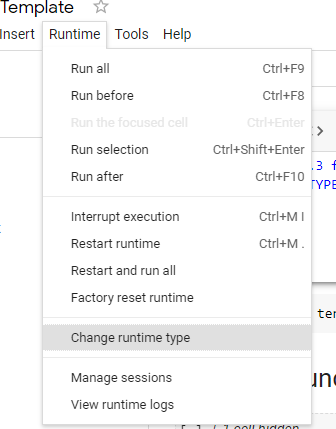
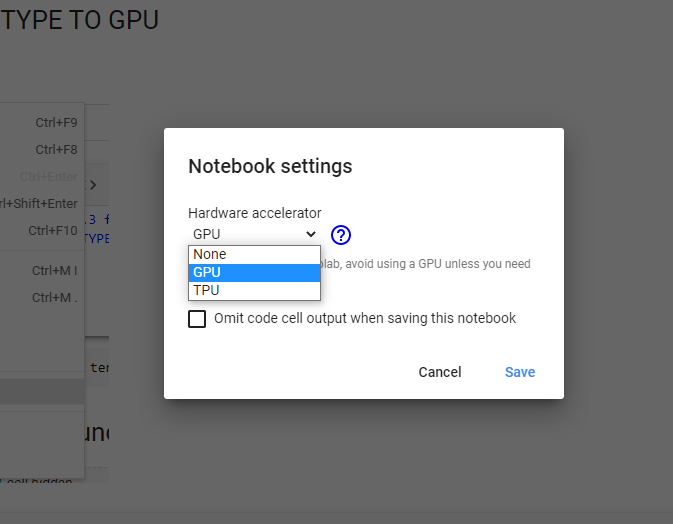


In [ ]:
!pip install tensorflow==2.3.0

# Premade Functions: Run ONCE, KEEP IT HIDDEN

In [25]:
# Visualising Images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
# Model Training
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#viewing random image
def view_random_image(target_dir, target_class):
  #setup the target directory 
  target_folder = target_dir + target_class
  #get a random image path
  random_image = random.sample(os.listdir(target_folder),1)
  #read image and plot
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");
  print(f"image shape: {img.shape}") #show image shape
  return img

# Model training function
def trainModel(train_dir, test_dir, modelNum, classes):
  tf.random.set_seed(42)
  #Preprocess data (get all the pixel values between 0 and 1)
  train_datagen = ImageDataGenerator(rescale = 1/255., horizontal_flip=True, vertical_flip=True)
  valid_datagen = ImageDataGenerator(rescale = 1/255., horizontal_flip=True, vertical_flip=True)

  #import data from directories and turn it into batches
  train_data = train_datagen.flow_from_directory(directory = train_dir,
                                                batch_size = 32,
                                                target_size = (224,224),
                                                class_mode = 'categorical',
                                                seed = 42)
  valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                                batch_size = 32,
                                                target_size = (224,224),
                                                class_mode = 'categorical',
                                                seed = 42)
  if(modelNum == 1):
    #build a CNN model
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv2D(filters = 10,
                              kernel_size = 3,
                              activation = 'relu',
                              input_shape = (224,224,3)),
        tf.keras.layers.MaxPooling2D(),

        tf.keras.layers.Conv2D(10, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(classes,activation = 'softmax')                                          
        ])
    
  elif(modelNum == 2):
      #build a CNN model
      model = tf.keras.models.Sequential([

          tf.keras.layers.Conv2D(filters = 10,
                                kernel_size = 3,
                                activation = 'relu',
                                input_shape = (224,224,3)),
          tf.keras.layers.MaxPooling2D(),

          tf.keras.layers.Conv2D(10, 3, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Conv2D(10, 3, padding='same', activation='relu'),
          tf.keras.layers.MaxPooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(classes,activation = 'softmax')                                          
          ])

  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
      monitor='val_loss', factor=0.1, patience=10, verbose=0,
      mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

  #compile our cnn
  model.compile(loss = "categorical_crossentropy",
                  optimizer = tf.keras.optimizers.Adam(),
                  metrics = ['accuracy'])

  #fit the model
  history = model.fit(train_data,
                          epochs = 15,
                          steps_per_epoch = len(train_data),
                          validation_data = valid_data,
                          validation_steps = len(valid_data),
                          callbacks=[reduce_lr])
  return model, history

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

# prep image for classifiation
def loadPrep(filename, shape = 224):
    image = tf.io.read_file(filename) #reading in image
    image = tf.image.decode_image(image) #decode into tensor
    image = tf.image.resize(image, size=[shape, shape]) #resizing
    image = image/255. #rescaling the image
    plt.imshow(image)
    return image

# Predict the image
def predPlot(model, filename, classnames):
    """
    Imports an image located at filename, makes a prediction on it with
    a trained model and plots the image with the predicted class as the title.
    """
    # Import the target image and preprocess it
    img = loadPrep(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    if len(pred[0]) > 1: # check for multi-class
      pred_class = class_names[pred.argmax()] # if more than one output, take the max
    else:
      pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    return pred

# Take photo with JS
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from IPython.display import Image

def take_photo(filename='123.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



---


# **STARTS HERE**
## Mount your Drive by running this code block


```
from google.colab import drive
drive.mount('/content/drive')
```
## Then, unzip your zip file by running this code
```
!unzip "drive/MyDrive/{zipfilename}.zip" # unzip your zip file
```



In [2]:
# Import Pictures from Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/multiclasstargets.zip" # unzip your zip file

---

## the !ls command lists out how many items there are in the folder, good for ensuring data is in the runtime, whereby {foldername} is your folder name without the curly braces
```
!ls "{foldername}"
```
## You can analyse how many items there are in each folder by running this codeblock, only modify {foldername}, the rest leave it

```
for dirpath, dirnames, filenames in os.walk("{foldername}"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")
```


In [4]:
!ls "multiclasstarget" # walk through your folder
import os
#walkthru directory and list no of files
for dirpath, dirnames, filenames in os.walk("multiclasstarget"):
  print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

test  train
there are 2 directories and 0 images in multiclasstarget
there are 3 directories and 0 images in multiclasstarget/train
there are 0 directories and 800 images in multiclasstarget/train/red
there are 0 directories and 800 images in multiclasstarget/train/white
there are 0 directories and 800 images in multiclasstarget/train/blue
there are 3 directories and 0 images in multiclasstarget/test
there are 0 directories and 200 images in multiclasstarget/test/red
there are 0 directories and 200 images in multiclasstarget/test/white
there are 0 directories and 200 images in multiclasstarget/test/blue




---



---


## You can get the class names automatically by running this code block


```
import pathlib
import numpy as np
data_dir = pathlib.Path("multiclasstarget/train") #enter your folder path here
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) #create a list of class names from the subdirectories
class_names = class_names # get class names
print(class_names) 
```



In [19]:
#getting class names
import pathlib
import numpy as np
data_dir = pathlib.Path("multiclasstarget/train") #enter your folder path here
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) #create a list of class names from the subdirectories
class_names = class_names # get class names

print(class_names) 

['blue' 'red' 'white']




---


## Then, you can run this codeblock to manually look at a random picture to inspect the data


```
img = view_random_image(target_dir = "{foldername}/{TRAIN OR TEST UP TO YOU}/", target_class= "{whatever class}")
```



image shape: (720, 1280, 3)


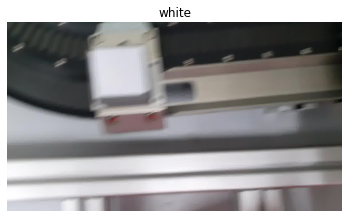

In [6]:
#view random image from training dataset
img = view_random_image(target_dir = "multiclasstarget/train/", target_class= "white") #enter your folder directory and the category

# **TRAINING THE MODEL**

---
## If all is smooth, you can then run the codeblock below to start training the model


```
model1, history1 = trainModel(train_dir={foldername}/train/", test_dir="{foldername}/test/", modelNum=1, classes = len(class_names))
```
## Whereby modelNum can only be 1(simple model) OR 2(more complex), and classes is how many classes there are in the dataset
## *p.s. len({listname}) give the number of elements in the list*

## Then, you can analyse the accuracy and loss curves with this block


```
plot_loss_curves(history1)
```






In [ ]:
model1, history1 = trainModel(train_dir="multiclasstarget/train/", test_dir="multiclasstarget/test/", modelNum=1, classes = len(class_names))

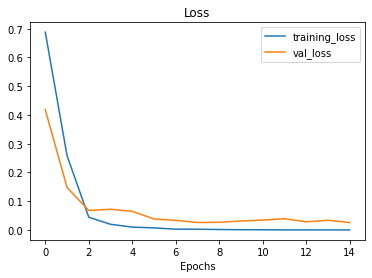

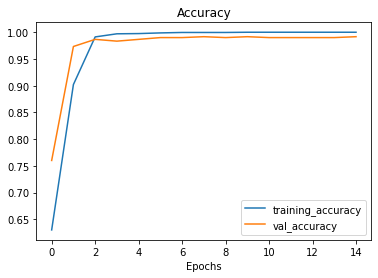

In [11]:
plot_loss_curves(history1)

#**REAL TIME TESTING**
## Run the below code block to take a picture and save it as 123.jpg

<IPython.core.display.Javascript object>

Saved to 123.jpg


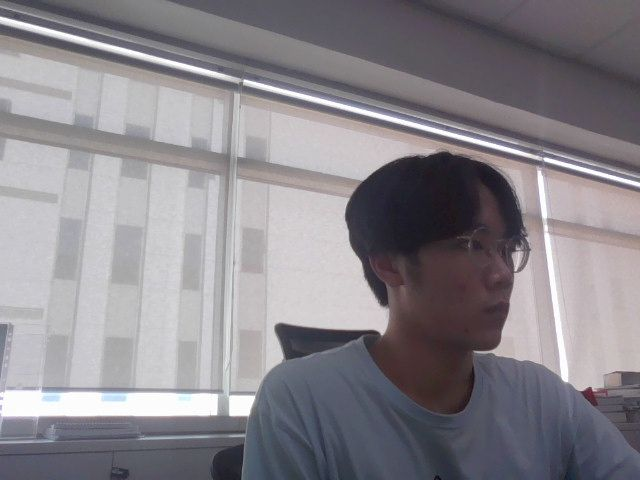

In [13]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## Test your model is real time with this codeblock



```
print(predPlot(model1, '123.jpg', class_names))
```
## whereby model1 is your model that you trained, 123.jpg is the picture you took, and class names is the list of class names you had declared early in the notebook


[[5.5289887e-02 1.4553774e-05 9.4469553e-01]]


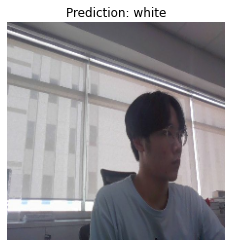

In [15]:
print(predPlot(model1, '123.jpg', class_names))

## Finally, you can save the model and download it on the toolbar on the left under files with this codeblock


```
model1.save("modelName.h5")
```



In [21]:
model1.save("MODEL1.h5")